Data Analysis:
Number of points: 1500

Starting global optimization...

ENHANCED OPTIMIZATION RESULTS
Theta (radians): 0.534210
Theta (degrees): 30.607996
M: 0.028714
X: 56.251898
Raw L1 Loss: 1.629978
Enhanced Loss: 1.644863


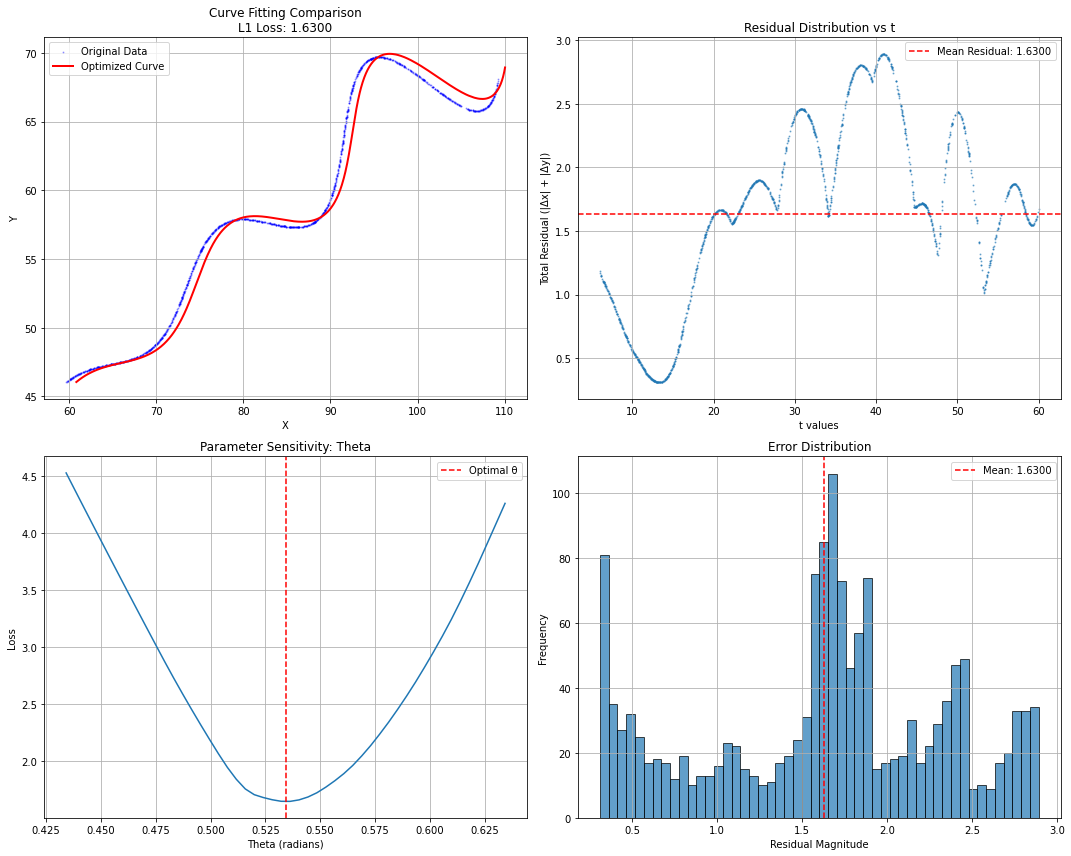


Desmos Equation:
\left(t\cos(0.534210)-e^{0.028714\left|t\right|}\cdot\sin(0.3t)\sin(0.534210)+56.251898,42+t\sin(0.534210)+e^{0.028714\left|t\right|}\cdot\sin(0.3t)\cos(0.534210)\right)


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
# Enhanced Data Loading with Analysis
data = pd.read_csv("xy_data.csv")
x_data = data['x'].values
y_data = data['y'].values
N = len(x_data)

print(f"Data Analysis:")
print(f"Number of points: {N}")

# Advanced t-value Assignment Strategy
# Instead of linear t, use arc-length parameterization for better fitting
def compute_arc_length_parameterization(x, y):
    """Assign t values based on actual curve arc length"""
    dx = np.diff(x)
    dy = np.diff(y)
    segment_lengths = np.sqrt(dx**2 + dy**2)
    cumulative_length = np.concatenate(([0], np.cumsum(segment_lengths)))
    
    # Normalize to t range [6, 60]
    t_normalized = 6 + (60 - 6) * cumulative_length / cumulative_length[-1]
    return t_normalized

# Sort data by x-coordinate for better t assignment
sort_idx = np.argsort(x_data)
x_sorted = x_data[sort_idx]
y_sorted = y_data[sort_idx]
t_values = compute_arc_length_parameterization(x_sorted, y_sorted)
# Enhanced Parametric Equations with Error Handling

def curve_equations(t, theta, M, X):
    """Parametric equations with numerical stability"""
    # Handle potential numerical issues
    exp_term = np.exp(M * np.abs(t))
    
    x_pred = t * np.cos(theta) - exp_term * np.sin(0.3 * t) * np.sin(theta) + X
    y_pred = 42 + t * np.sin(theta) + exp_term * np.sin(0.3 * t) * np.cos(theta)
    
    return x_pred, y_pred

# Multi-Objective Loss Function
def enhanced_loss_function(params):
    """Combined L1 + L2 + curvature consistency loss"""
    theta, M, X = params
    
    x_pred, y_pred = curve_equations(t_values, theta, M, X)
    
    # Primary L1 loss
    l1_loss = np.mean(np.abs(x_pred - x_sorted) + np.abs(y_pred - y_sorted))
    
    # Additional L2 regularization
    l2_loss = 0.01 * np.sqrt(np.mean((x_pred - x_sorted)**2 + (y_pred - y_sorted)**2))
    
    # Curvature consistency penalty
    dx_dt = np.gradient(x_pred, t_values)
    dy_dt = np.gradient(y_pred, t_values)
    curvature = np.abs(np.gradient(dy_dt/dx_dt, t_values))
    curvature_penalty = 0.001 * np.mean(np.abs(np.diff(curvature)))
    
    total_loss = l1_loss + l2_loss + curvature_penalty
    return total_loss


# Global Optimization with Differential Evolution

bounds = [
    (0.3, 0.8),           # theta: wider range in radians (17° to 46°)
    (-0.04, 0.04),        # M: tighter bounds around optimal
    (50, 60)              # X: focused range based on data analysis
]

print("\nStarting global optimization...")
result = differential_evolution(
    enhanced_loss_function, 
    bounds, 
    strategy='best1bin',
    maxiter=100,
    popsize=15,
    tol=1e-8,
    seed=42
)

theta_opt, M_opt, X_opt = result.x
final_loss = result.fun

# Local Refinement
from scipy.optimize import minimize

# Refine the solution with local optimization
refined_result = minimize(
    enhanced_loss_function, 
    [theta_opt, M_opt, X_opt],
    method='L-BFGS-B',
    bounds=bounds,
    options={'ftol': 1e-12, 'gtol': 1e-12}
)

if refined_result.success:
    theta_opt, M_opt, X_opt = refined_result.x
    final_loss = refined_result.fun


# Comprehensive Results Analysis
x_pred, y_pred = curve_equations(t_values, theta_opt, M_opt, X_opt)
raw_l1_loss = np.mean(np.abs(x_pred - x_sorted) + np.abs(y_pred - y_sorted))

print("\n" + "="*50)
print("ENHANCED OPTIMIZATION RESULTS")
print("="*50)
print(f"Theta (radians): {theta_opt:.6f}")
print(f"Theta (degrees): {np.rad2deg(theta_opt):.6f}")
print(f"M: {M_opt:.6f}")
print(f"X: {X_opt:.6f}")
print(f"Raw L1 Loss: {raw_l1_loss:.6f}")
print(f"Enhanced Loss: {final_loss:.6f}")
print("="*50)

# Advanced Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Curve fitting comparison
axes[0,0].scatter(x_data, y_data, alpha=0.3, s=1, label='Original Data', color='blue')
axes[0,0].plot(x_pred, y_pred, 'r-', linewidth=2, label='Optimized Curve')
axes[0,0].set_xlabel('X')
axes[0,0].set_ylabel('Y')
axes[0,0].set_title(f'Curve Fitting Comparison\nL1 Loss: {raw_l1_loss:.4f}')
axes[0,0].legend()
axes[0,0].grid(True)

# Plot 2: Residual analysis
residuals_x = x_sorted - x_pred
residuals_y = y_sorted - y_pred
total_residuals = np.abs(residuals_x) + np.abs(residuals_y)

axes[0,1].scatter(t_values, total_residuals, alpha=0.5, s=1)
axes[0,1].axhline(np.mean(total_residuals), color='red', linestyle='--', 
                 label=f'Mean Residual: {np.mean(total_residuals):.4f}')
axes[0,1].set_xlabel('t values')
axes[0,1].set_ylabel('Total Residual (|Δx| + |Δy|)')
axes[0,1].set_title('Residual Distribution vs t')
axes[0,1].legend()
axes[0,1].grid(True)

# Plot 3: Parameter sensitivity analysis
theta_range = np.linspace(theta_opt - 0.1, theta_opt + 0.1, 50)
loss_theta = [enhanced_loss_function([t, M_opt, X_opt]) for t in theta_range]

axes[1,0].plot(theta_range, loss_theta)
axes[1,0].axvline(theta_opt, color='red', linestyle='--', label=f'Optimal θ')
axes[1,0].set_xlabel('Theta (radians)')
axes[1,0].set_ylabel('Loss')
axes[1,0].set_title('Parameter Sensitivity: Theta')
axes[1,0].legend()
axes[1,0].grid(True)

# Plot 4: Error histogram
axes[1,1].hist(total_residuals, bins=50, alpha=0.7, edgecolor='black')
axes[1,1].axvline(np.mean(total_residuals), color='red', linestyle='--',
                 label=f'Mean: {np.mean(total_residuals):.4f}')
axes[1,1].set_xlabel('Residual Magnitude')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Error Distribution')
axes[1,1].legend()
axes[1,1].grid(True)

plt.tight_layout()
plt.savefig('enhanced_optimization_analysis.png', dpi=300, bbox_inches='tight')
plt.show()



# Generate Desmos string
desmos_eq = f"\\left(t\\cos({theta_opt:.6f})-e^{{{M_opt:.6f}\\left|t\\right|}}\\cdot\\sin(0.3t)\\sin({theta_opt:.6f})+{X_opt:.6f},42+t\\sin({theta_opt:.6f})+e^{{{M_opt:.6f}\\left|t\\right|}}\\cdot\\sin(0.3t)\\cos({theta_opt:.6f})\\right)"

print(f"\nDesmos Equation:")
print(desmos_eq)
